# MS-E2122 - Nonlinear Optimization
### Prof. Fabricio Oliveira
 
## Homework 4 - Problem 4.1

In [1]:
using JuMP
using Clp
using Random
using Test
using LinearAlgebra
using ForwardDiff

∇(f, x) = ForwardDiff.gradient(f, x)
d(θ, λ) = ForwardDiff.derivative(θ, λ)

d (generic function with 1 method)

We provide an implementation of the Armijo line search (which you have implemented in the past, so no need to reimplement).

In [2]:
function armijo(θ; λ=1.0, α=0.01, β=0.7) 
    
    θ₀  = θ(0)                 # Function value at zero (use \theta + tab and \_0 + tab to add the subscript to θ)
    dθ = d(θ, 0)               # Derivative (slope) at zero   
    
    while θ(λ) > θ₀ + α*λ*dθ   # Check termination condition
        λ = β*λ                # Reduce λ until condition is satisfied
    end
    
    return λ
end

armijo (generic function with 1 method)

## Problem 4.1 - Frank-Wolfe method

We use a function that assumes the problem in the form of
$
\begin{align*}
    \text{min. }_x & (1/2)||Ax - b||_2^2  \\
    \text{s.t.: }  & ||x||_1 \le c  
\end{align*}
$


Therefore, the inputs are:
- Problem instance: matrix $A$, vector $b$ of adequate sizes and a scalar $c$ defining the maximum value for the $L_1$-norm of the vector.

 Output
- f(xᵏ) - optimal objective value 
- xᵏ - optimal solution
- k - total of iterations.

In [7]:
function frank_wolfe(A, b, c; max_iter=500, ϵ=1e-2)

    # Objective function to be minimized
    f(x) = 0.5*dot(A*x - b, A*x - b)
    
    (m,n) = size(A) # Obtaining problem dimension
    xᵏ  = zeros(n)  # Initial values set to zeros, as it is always feasible
    k  = 1          # Iteration counter 

    model = Model(optimizer_with_attributes(Clp.Optimizer)) 
    set_silent(model)  # Omits solver output  
    @variable(model, x[1:n])
    @variable(model, y[1:n] >= 0)
    @constraint(model, sum(y[j] for j in 1:n) <= c)
    @constraint(model, [j=1:n], x[j] <= y[j])
    @constraint(model, [j=1:n], x[j] >= -y[j])
    
    # TODO: Implement the objective function of the linearised problem using xᵏ and ∇(f, xᵏ)
    #dot(∇(f, xᵏ),x - xᵏ) 
    #transpose(∇(f, xᵏ))*(x- xᵏ)
    @objective(model, Min, dot(∇(f, xᵏ), x - xᵏ)) #since xᵏ = 0 it's not actually needed
    
    optimize!(model)  # Optimise the model  
    x̄ᵏ = value.(x)    # Store x̄ᵏ = argmin{x ∈ ℜⁿ : ∇f(xᵏ)ᵀ(x - xᵏ), x ∈ S}  
    
    # TODO: update the improving feasible direction dᵏ
    dᵏ = x̄ᵏ - xᵏ
    
    # TODO: update the new point xᵏ using λ = 1 for the first step and dᵏ
    xᵏ = xᵏ + (dᵏ)
    
    println("Algorithm started. Initial residual: ", round(dot(∇(f, xᵏ), dᵏ), digits=5))
    while dot(∇(f, xᵏ), dᵏ) > ϵ  && k <= max_iter
        k  = k + 1 # Iteration counter
        
        # TODO: Update the objective function of the linearised problem
        @objective(model, Min, dot(∇(f, xᵏ), x))
        
        optimize!(model)
        x̄ᵏ = value.(x)

        # TODO: update the improving feasible direction dᵏ
        dᵏ = x̄ᵏ - xᵏ

        # Armijo line search (any line search would be ok)
        θ(λ) = f(xᵏ + λ*dᵏ)
        λ    = armijo(θ)
        
        # TODO: update the new point xᵏ now using λ and dᵏ
        xᵏ = xᵏ + λ*dᵏ

        if k % 10 == 0 # print every 10 iterations
            println("   residual: ", round(dot(∇(f, xᵏ), dᵏ), digits=5), " / iter: ", k)
        end
    end
    println("Converged. Final residual: ", round(dot(∇(f, xᵏ), dᵏ), digits=5), " / total iters: ", k)
    return (f(xᵏ), xᵏ, k) 
end

frank_wolfe (generic function with 1 method)

Let's now generate a random instance with 100 features and a 1000 data points. Notice we then call the function to solve the problem.

In [4]:
# Generate random data. NOTE: do not rerun
Random.seed!(1)
M   = 1000
N   = 100
A   = rand(M,N)
b   = rand(M)
c   = 0.8; # sets the desired sparsity level (regularisation coefficient) in the optimal solution.

In [8]:
# Solve model
(obj, xᵏ, k) = frank_wolfe(A,b,c)

# Print solution
println("  Iterations: ", k)
println("Optimal cost: ", round(obj, digits = 2))

Algorithm started. Initial residual: 20.88431


   residual: 10.92661 / iter: 10


   residual: 2.12459 / iter: 20


   residual: 1.10537 / iter: 30


   residual: 1.26784 / iter: 40


   residual: 1.06271 / iter: 50


   residual: 0.35133 / iter: 60


   residual: 0.47225 / iter: 70


   residual: 0.29754 / iter: 80


   residual: 0.22022 / iter: 90


   residual: 0.0985 / iter: 100


   residual: 0.12218 / iter: 110


   residual: 0.12773 / iter: 120


   residual: 0.04371 / iter: 130


   residual: 0.04609 / iter: 140


   residual: 0.03134 / iter: 150


   residual: 0.01622 / iter: 160


   residual: 0.02521 / iter: 170
Converged. Final residual: 0.00937 / total iters: 173
  Iterations: 173
Optimal cost: 42.94


In [9]:
# Testing to check the implementation.
@test k == 173
@test obj ≈ 42.93599637615333

Test Passed

## Problem 4.2 - Interior point method

We will implement a primal-dual interior point method to solve a quadratic problem of the form

$
\begin{align*}
\text{min. } & c^\top x + \frac{1}{2}x^\top Q x \\
\text{s.t.: } & Ax = b \\
& x \ge 0.
\end{align*}
$

In [170]:
using JuMP
using Clp
using Random
using LinearAlgebra
using ForwardDiff
using Plots
pyplot();

We start by defining auxiliary function that we will use in the main routine. Notice that you are only required to complete the function `update_newton_direction` which has as inputs
- The vector $c$, the matrices $Q$ and $A$, and vector $c$;
- The current primal variable value $x$, dual variables $u$ and $v$;
- and the penalty term $\mu$.

The outputs are the updated directions $d_v, d_u, d_x$.

The function `calculate_step_size` is used to define a step size to retain feasibility.

In [206]:
"""
Auxiliary function: does the update of the Newton direction                             
"""
# Update Newton direction
function update_newton_direction(A, b, c, Q, x, u, v, μ)   
    # Diagonalize u and x
    U = Diagonal(u)
    X = Diagonal(x)
    e = ones(length(x))
    
    # Primal and dual residuals
    rp = A*x - b
    rd = A'*v + u - c - Q*x
    
    
    # TODO: Derive and write the Newton update formulas for each component
    rc = X*U*e-μ*e  #Manually added
    term1 = inv(U+X*Q)
    dᵥ = inv(A*term1*X*A')*(-rp + A*term1*(rc-X*rd) )
    dₓ = term1*(-rc+X*rd+X*A'*dᵥ)
    dᵤ = -rd+Q*dₓ-A'*dᵥ

   
    return (dᵥ,dᵤ,dₓ)
end

"""
Auxiliary function: calculate step size that retains feasibility                             
"""
function calculate_step_size(x, d, ϵ)
    n = length(d)
    α = 1.0 - ϵ
    for i = 1:n
        if d[i] < 0
            α = min(α, -x[i]/d[i]) # prevents variable becoming negative
        end
    end
    return round(α, digits = Int(-log10(ϵ))) #rounding avoids numerical issues
end

calculate_step_size

This is the main function which is completely provided for you.

In [207]:
"""
 Solve the QP problem and its dual                                          

 P: minimize   cᵀx + (1/2)xᵀQx        D: maximize    bᵀv - (1/2)xᵀQx             
   subject to  Ax = b                    subject to  Aᵀv + u - Qx = c            
               x ≥ 0                                        u ≥ 0                                        
"""
function primal_dual_ip(A, b, c, Q; β=0.3, μ= 10.0, ϵ=1e-6, N=50)

    n = length(c)    # Number of primal variables x and dual variables u
    m = length(b)    # Number of dual variables v
    x = zeros(N, n)  # Primal variable x values
    u = zeros(N, n)  # Dual variable u values
    v = zeros(N, m)  # Dual variable v values
    α_p = 1          # Step size for variable x update
    α_d = 1          # Step size for variable u, and v update

    # Feed an initial solution (cannot use zeros, as it breaks the Newton step due to the inversions of 
    # U and V; any ≠ 0 initial point is good for these x and u. v can be safely initialised as zero)
    x₀ = ϵ * ones(n)
    u₀ = x₀

    u[1,:] = u₀
    x[1,:] = x₀      # Note v₀ initialised as 0

    # Main loop
    for i = 1:N
        # Stopping condition #1
        if n*μ < ϵ           # equivalent to if dot(c,x[i,:]) - dot(b,v[i,:]) < ϵ
            v = v[1:i,:]
            u = u[1:i,:]
            x = x[1:i,:]
            return (v,u,x)
        end
        # Update dₓ, dᵥ, dᵤ
        (dᵥ,dᵤ,dₓ) = update_newton_direction(A, b, c, Q, x[i,:], u[i,:], v[i,:], μ)

        # Calculate step size α primal and α dual
        α_p = calculate_step_size(x[i,:], dₓ, ϵ)
        α_d = calculate_step_size(u[i,:], dᵤ, ϵ)

        # Update variables
        v[i+1,:] = v[i,:] + α_d*dᵥ
        u[i+1,:] = u[i,:] + α_d*dᵤ
        x[i+1,:] = x[i,:] + α_p*dₓ

        # Stopping condition #2
        if i == N-1
            return (v,u,x)
        end
        # Update μ
        μ = μ*β
    end
end

primal_dual_ip

Below we provide a numerical example so you can test your code. Notice that the linear constraints are given in the standard form, that is, with additional nonnegative slack variables to convert the inequalities into equalities. 

Although the original problem has only 2 variables, the final problem has a total of 7, with 5 additional variables for each inequality constraint.

In [208]:
# Problem data in standard form.
# min      -x₁ - x₂ + ⁠(1/2)xᵀQx
# s.t.: -1/3x₁ + x₂ + x₃                 =  5
#        1/5x₁ - x₂     + x₄             = -1
#       -8/3x₁ - x₂         + x₅         = -8
#        1/2x₁ + x₂             + x₆     =  9
#           x₁ - x₂ +               + x₇ =  4
#           x₁, ... ,x₇ ≧  0

Random.seed!(1)
c = [-1.0,-1.0, 0.0,0.0,0.0,0.0,0.0]
b = [ 5.0,-1.0,-8.0,9.0,4.0]
A = [-1/3  1.0 1.0 0.0 0.0 0.0 0.0;
      1/5 -1.0 0.0 1.0 0.0 0.0 0.0;
     -8/3 -1.0 0.0 0.0 1.0 0.0 0.0;
      1/2  1.0 0.0 0.0 0.0 1.0 0.0;
      1.0 -1.0 0.0 0.0 0.0 0.0 1.0]

# Create a random positive definite (PD) matrix Q for the quadratic term
n = length(c)
Q = randn(n, n)                # Create random matrix
Q = (Q + Q')/2                 # Make Q symmetric
if isposdef(Q) == false        # Check if Q is PD
    λmin = eigmin(Q)           # Minimum eigenvalue
    Q = Q + (abs(λmin) + 1)*I  # Add λmin + 1 to diagonal elements
end
Q[3:n,:] .= 0.0                # Set zero values for slack variables
Q[:,3:n] .= 0.0

# Solution time (run it twice to calculate the time after everything required is properly compiled)
(v,u,x) = primal_dual_ip(A, b, c, Q)
@time (v,u,x) = primal_dual_ip(A, b, c, Q);

  0.000246 seconds (988 allocations: 265.703 KiB)


Here is a visual representation of the algorithm process. Notice we only plot for $(x_1,x_2)$. Feel free to try different values for the parameters $\mu$ and $\beta$ to see how they influence the trajectory and number of steps taken.

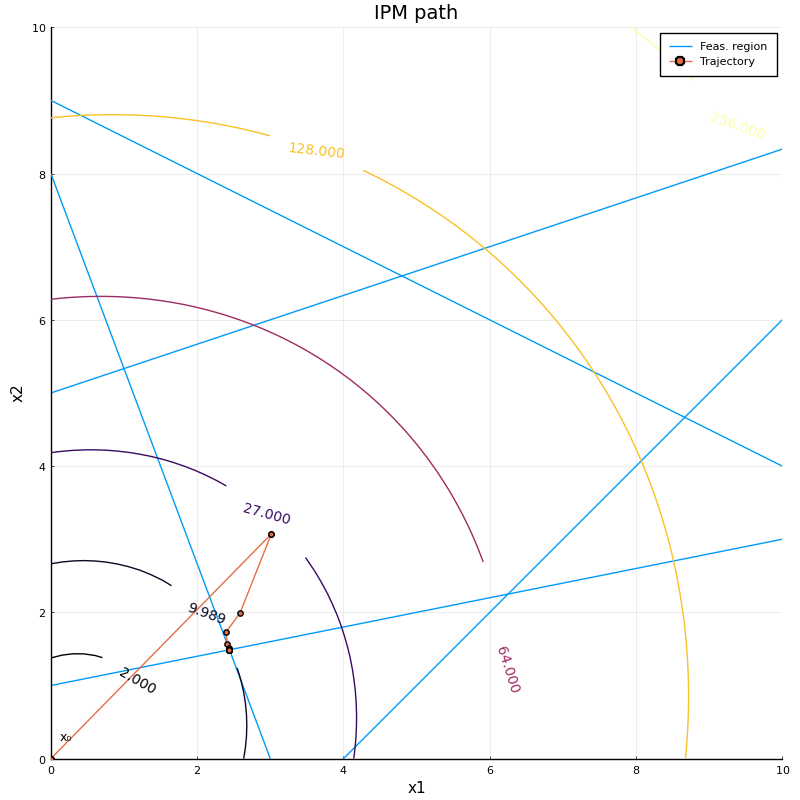

In [209]:
## Plotting
ng = 100
x1 = range(0, 15, length=ng)
x2 = x1

plot(x1, 5 .+ (1/3).*x1,  color = :1, label = "Feas. region")
plot!(x1, 1 .+ (1/5).*x1, color = :1, label = "")
plot!(x1, 8 .- (8/3).*x1, color = :1, label = "")
plot!(x1, 9 .- (1/2).*x1, color = :1, label = "")
plot!(x1, -4 .+ x1, color = :1,
      xaxis  = ("x1", (0,10)),
      yaxis  = ("x2", (0,10)),
      aspect_ratio = :equal,
      size   = (800,800),
      label = "",
      title  = "IPM path")

g(x) = dot(c[1:2],x) + (1/2)*dot(x,Q[1:2,1:2]*x)

contour!(x1, x2, (x1, x2) -> g([x1, x2]),
        levels  = [2, g(x[end,1:2]), 27, 64, 128, 256],
        clims   = (0,150),
        clabels = true,
        cbar = false)

traj = x[1:end,1:2]
annotate!(traj[1,1] + 0.2, traj[1,2] + 0.2, text("x₀",9,:bottom))

display(plot!(traj[:,1], traj[:,2], marker = :o, color = :2, label = "Trajectory"))
savefig("Plots/qp_convergence.png")

## Problem 4.3 - Sequential quadratric programming

We will implement a SQP code to solve problems of the form

$
\begin{align*}
    \text{min. } & f(x) \\
    \text{s.t.: } & g(x) \le 0.  
\end{align*}
$

Both $f: \reals^s \rightarrow \reals$ and $g: \reals^2 \rightarrow \reals$ are assumed to be potentially nonlinear and have a two-dimensional arguments. Notice that there are no equality constraints.

The function `sqp` has as inputs
- $f$: the objective function to be minimised
- $g$: an array of functions $g$ representing the constraints.
- $\mu$: penalty term associated with the inequalities
- $\Delta$: trust region size, assumed constant in this case.
- $\epsilon$: tolerance
- $N$: maximum number of iterations.

In [210]:
using JuMP
using Ipopt
using LinearAlgebra
using ForwardDiff
using Test
using Plots

# Gradient and Hessian
∇(f,x)  = ForwardDiff.gradient(f,x)
∇²(f,x) = ForwardDiff.hessian(f,x)

∇² (generic function with 1 method)

In [236]:
function sqp(f, g; μ=10.0, Δ=1.0, ϵ=1e-6, N=50)
    # Initialize parameters
    k = 1             # Iteration count
    n = 2             # Number of dimensions of x
    m = length(g)     # Number of constraints
    xᵏ = zeros(n)     # Initial primal solution
    uᵏ = zeros(m)     # Initial dual solution
    x  = zeros(n, N)  # Save trajectory of iteration
    x[:,k] = xᵏ       # Set initial value
   
    # Defining the Lagrangian function and its Hessian
    L(x,u) = f(x) + sum(u[i]*g[i](x) for i=1:m)
    ∇²L(x,u) = ∇²(f,x) + sum(u[i] *∇²(g[i],x) for i=1:m)  # g₂, g₃, and g₄ vanish as they are linear.

    # Main loop
    for k = 1:N-1
        xᵏ = x[:,k]
        
        # Precompute ∇f, ∇g, and ∇L² for efficiency
        ∇fᵏ  = ∇(f,xᵏ)
        ∇gᵏ  = [∇(g[i], xᵏ) for i=1:m]
        ∇²Lᵏ = ∇²L(xᵏ,uᵏ)
        gᵏ   = [g[i](xᵏ) for i=1:m]

        # Projected Lagrangian subproblem (Direction search)
        QP = Model(Ipopt.Optimizer)
        @variable(QP, d[1:n])
        @variable(QP, y[1:m] >= 0)
        
        # TODO: implement the objective function and constraints in the QP subproblem for the l1-SQP. The code requires that the
        # linearisation of g is called 'LinearIneq', which requires it to be defined as:
        # @constraint(QP, LinearIneq[i = 1:m], ... )
        
        @constraint(QP, LinearIneq[i = 1:m], y[i] >= gᵏ[i] + dot(∇gᵏ[i],d))
        @constraint(QP, NegDelta[i = 1:n],-Δ <= d[i])
        @constraint(QP, PosDelta[i = 1:n], Δ >= d[i])

        @expression(QP, grad, dot(∇fᵏ,d))
        @expression(QP, hess, 1/2*(transpose(d)*∇²Lᵏ)*d)
        @expression(QP, penalty, μ*sum(y[i] for i=1:m))
        
        @objective(QP,Min, grad + hess + penalty)
        #println(QP)

        optimize!(QP)

        dᵏ = value.(d)            # Obtain new direction
        x[:,k+1] = xᵏ + dᵏ        # Update primal solution
        uᵏ = dual.(LinearIneq)    # Obtain optimal dual solution

        ## Check stopping condition
        if norm(dᵏ) < ϵ
            return x = x[:,1:k+1]
        end
    end 
end

sqp (generic function with 1 method)

In [237]:
# Problem data

# Objective function
f(x)   = 2x[1]^2 + 2x[2]^2 - 2(x[1]*x[2]) - 4x[1] - 6x[2]

# Constraint functions
g₁(x) = x[1]^2 - x[2]     # ≦ 0
g₂(x) = x[1] + 5x[2] - 5  # ≦ 0
g₃(x) = -x[1]             # ≦ 0
g₄(x) = -x[2]             # ≦ 0

cons = [g₁, g₂, g₃, g₄]

x = sqp(f,cons)
# Try different values for μ such as 100.0, or 1000.0. Also, try larger and smaller values for the trust region Δ,
# such as 0.5 or 100.0.

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       13
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        4
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        8
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

2×6 Array{Float64,2}:
 0.0  1.0  0.909091  0.904996  0.904988  0.904988
 0.0  0.8  0.818182  0.819001  0.819002  0.819002

Testing whether the code converged to the right solution. TIP: in case you are having trouble debugging your model, try to to add a prin instruction of the final model (`println(QP)`) AFTER you have added the constraints in the function `sqp()`. The model is printed in a formated form that allows to see which variables and constraints are being created.

In [238]:
@test round.(x[:,end], digits=5) ≈ [0.90499;0.819]

Test Passed

Here is a plot showing the trajectory of the algorithm.

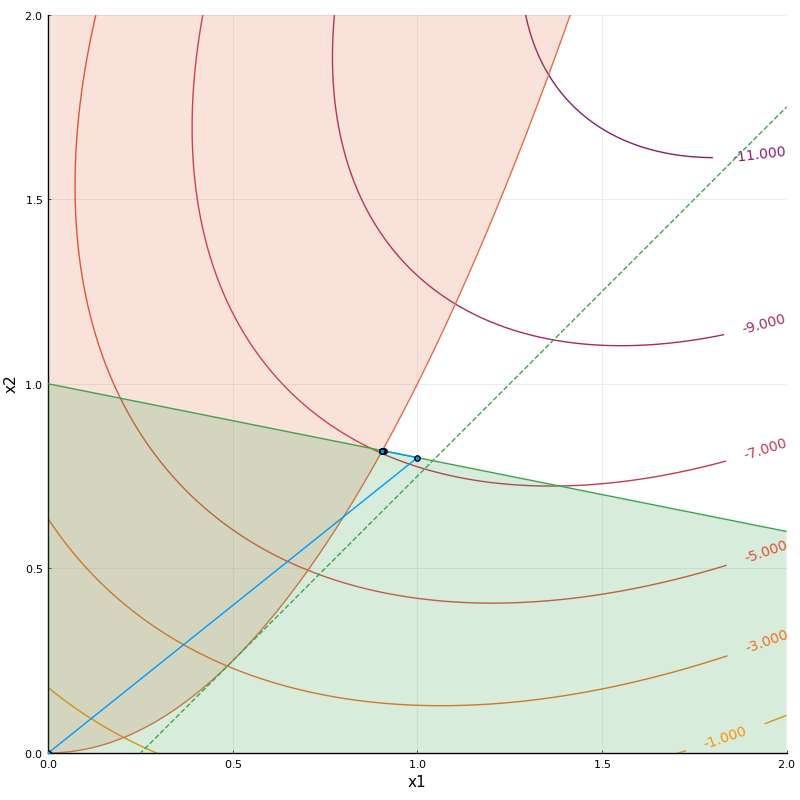

In [239]:
# Plotting
n  = 1000
x1 = range(-1,2,length=n)
x2 = x1
# z  = [f([x1[i],x2[j]]) for j = 1:n, i = 1:n]

# Contours of the objective
contour(x1, x2, (x1,x2)->f([x1,x2]),
        levels  = [-11, -9, -7, -5, -3, -1],
        clims = (-20,5),
        clabels = true,
        legend = false)
# Plot the feasible region
plot!(x1, x1.^2, fill = (10,0.2), color = 2)
plot!(x1, 1 .- (1/5).*x1, fill = (0,0.2), color = 3,
      xaxis = ("x1", (0,2)),
      yaxis = ("x2", (0,2)),
      aspect_ratio = :equal,
      size = (800,800),
      legend = false)
# Plot the trejectory of iterations
plot!(x[1,:], x[2,:], marker = :o, color = 1)

# First order approximation at initial point of constraint 1
display(plot!(x1, -0.25 .+ x1, color = 3, line = :dash))

savefig("Plots/SQP_example.png")